# Select C-type asteroids from the Gaia DR3 reflectance spectra
Run an initial classification of asteroids into C-types and "the rest" using a neural network classifier. Code is based on [the notebook by Joost Barendse](https://github.com/joostbar/asteroids).

The Gaia DR3 data was simply downloaded in full with the query:
```sql
select * from gaiadr3.sso_reflectance_spectrum
```
The reflectance spectra are corrected according to the prescriptions by [Tinaut-Ruano et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...669L..14T/abstract). The factors by which to multiply the `reflectance_spectrum` column are listed in their table 1.

| Wavelength (nm) | Correction Factor |
| -- | -- |
| 374.0 | 1.07 |
| 418.0 | 1.05 |
| 462.0 | 1.02 |
| 506.0 | 1.01 |

Additional data on the asteroids, their proper orbital elements, inverse diameters and magnitudes $H$, were downloaded from the [MP3C](https://mp3c.oca.eu/) database (on November 18 2023). An unconstrained "best values" search was done to get all data. These data are added to the table created with `create_sso_objects_file.py`. This was done by merging the tables in [topcat](https://www.star.bris.ac.uk/~mbt/topcat/) using the exact match on MPC numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import HistEqStretch, ImageNormalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.neural_network import MLPClassifier

from astropy.table import Table

from tqdm import tqdm

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from reflspectratools import (
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
    prep_classifier_inputs,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)

## Read in the data
Read the Gaia DR3 data and the classified asteroid MPC numbers for use in ML classification training and application.

__NOTE__ that for the initial seperation of C-types from the rest of the asteroids the full range of wavelengths should be used for the spectra. That this is the case can be checked by re-running with `ssodata = load_dr3_data(clipspectra=True)`.

In [2]:
ssospectra = load_dr3_data(clipspectra=False)
n_asteroids = ssospectra.number_mp.unique().size
wavelengths = ssospectra["wavelength"].unique()
wavelengths.sort()
ssotypes = create_ml_training_classes(ssospectra, filter=True)

ssoparams = Table.read("./data/DR3ReflectanceSpectraMP3C.fits").to_pandas()
ssoparams["denomination"] = ssoparams.denomination.str.decode("utf-8")
ssoparams["parent_name"] = ssoparams.parent_name.str.decode("utf-8")

## Classification of C-type vs other
Train an ML algorithm to classify C-Type vs other types of asteroids. Use the type labels from the asteroids classified by Joost and Marco.

The code below carries out the following steps:
* Run the training and classification $n=l\times m$ times with $l$ different random realizations of the reflectance spectra and $m$ different random states for `sklearn.neural_network.MLPClassifier`
    * This repeated training and running of the classifier is meant to account for the observational uncertainties and for the stochastic nture of the MLPClassifier (I have not yet found a few to get repeatable results, despite using a fixe set of random states).
* The MLPClassifier is instantiated with `early_stopping=True` which means that automatically 10 per cent of the training data is set aside for validation
* After each training step, apply the classifier to all asteroids by predicting their class probabilities.
    * The probablity of being C-type is stored in a $n\times n_\mathrm{asteroids}$ matrix
    * So for each asteroids $n$ samples of the class probability are available
* In the subsequent code blocks the average class probablity $\theta$ (over the $m$ runs) and the scatter of the class probabilities $\zeta$ are used to decide on the classification of asteroids
    * An asteroid with a combination of high $\theta$ and small $\zeta$ is considered to be of C-type
    * An asteroid with a combination of low $\theta$ and small $\zeta$ is considered to be of other type
    * Other asteroids have uncertain classifications

100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


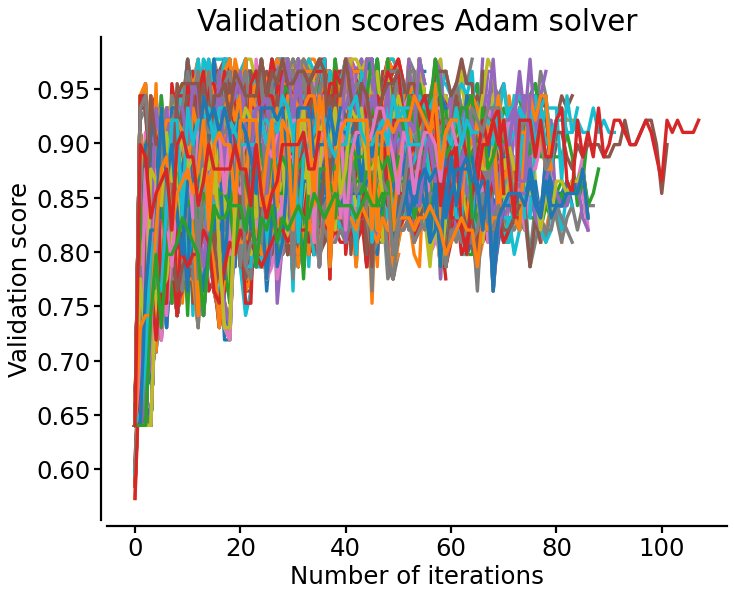

In [3]:
# Run the algorithm m times, each time with a different random state.
mnoise = 32
mclf = 32
probability_matrix = np.zeros((mclf * mnoise, n_asteroids))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
apply_tufte(ax)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Validation score")
ax.set_title("Validation scores Adam solver")

# train and classify with an ensemble of neural networks

for j in range(mnoise):
    if j == 0:
        rrng = None
    else:
        rrng = np.random.default_rng(j)
    training_spectra, training_labels, data_to_be_classified = prep_classifier_inputs(
        ssospectra, ssotypes, rng=rrng
    )
    for jj in tqdm(range(mclf)):
        clf = MLPClassifier(
            solver="adam",
            alpha=1e-05,
            batch_size=100,
            activation="tanh",
            hidden_layer_sizes=(200, 200, 200, 200),
            max_iter=200,
            random_state=jj,
            early_stopping=True,
            n_iter_no_change=25,
        )
        clf.fit(training_spectra, training_labels)
        ax.plot(clf.validation_scores_)

        ctype_index = np.argwhere(clf.classes_ == 1).ravel()[0]
        probability_matrix[j * mclf + jj, :] = clf.predict_proba(data_to_be_classified)[
            :, ctype_index
        ]

plt.show()

### Examine the results
First the mean and median probabilities and their standard deviations and RSEs are stored in the `ssoparams` DataFrame. This table is then used to plot various aspects of the results. Below these statistics are further examined to investigate what combination of average and scatter is best for selecting C-type asteroids.

In [4]:
ssoparams["ctype_median_prob"] = np.median(probability_matrix, axis=0)
ssoparams["ctype_rse_prob"] = rse(probability_matrix, ax=0)
ssoparams["ctype_mean_prob"] = np.mean(probability_matrix, axis=0)
ssoparams["ctype_std_prob"] = np.std(probability_matrix, axis=0)
Table.from_pandas(ssoparams).write(
    "./outputs/DR3ReflSpecCvsOtherType.fits", format="fits", overwrite=True
)

### Histograms of class probabilities
Histograms of $\theta$ are shown below for different thresholds on $\zeta$. A clear seperation between $\theta\sim0$ and $\theta\sim1$ starts to appear for $\zeta\lesssim0.1$. The separation depends on which combination of median or mean class probability and RSE or standard deviation is used. More asteroids are selected with the combination of mean probability and the RSE. This is investigated further below.

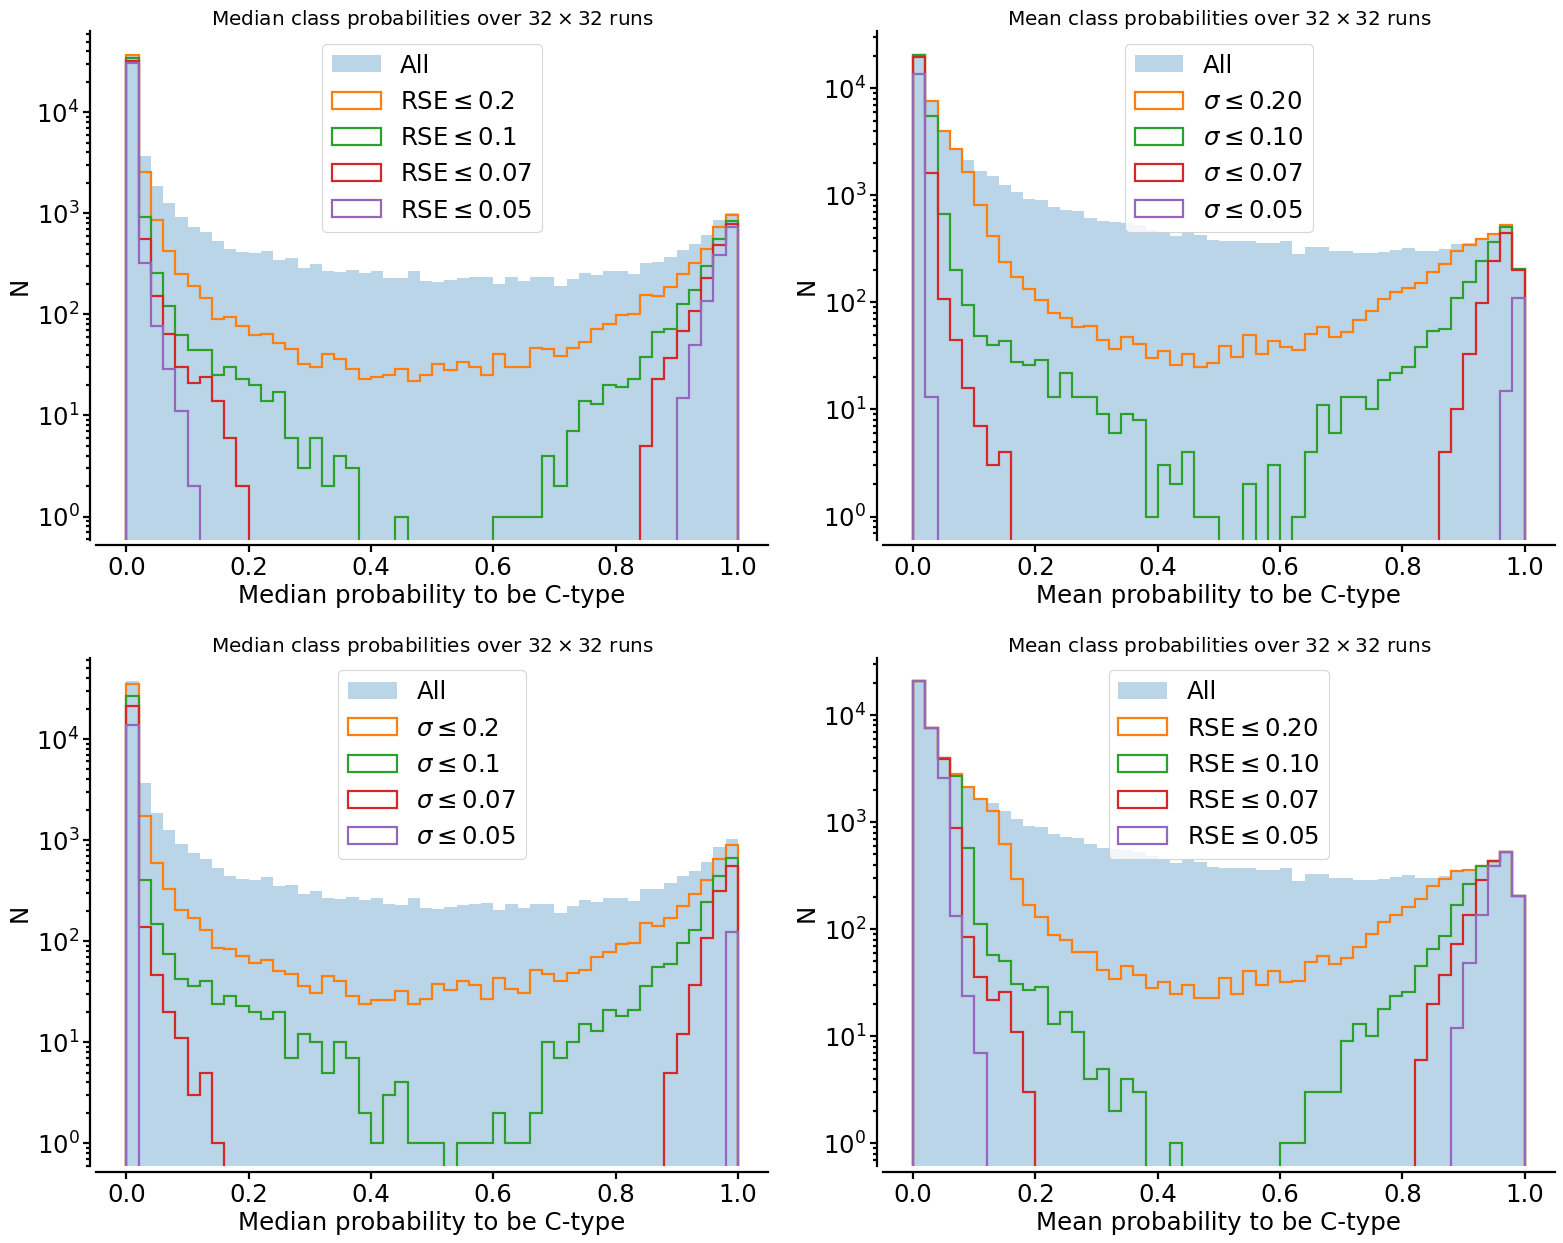

In [5]:
fig = plt.figure(figsize=(2 * 10, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axhists = []
axhists.append(fig.add_subplot(gs[0, 0]))
axhists.append(fig.add_subplot(gs[0, 1]))
axhists.append(fig.add_subplot(gs[1, 0]))
axhists.append(fig.add_subplot(gs[1, 1]))
for ax in axhists:
    apply_tufte(ax)

nbins = 50
rselims = [0.2, 0.1, 0.07, 0.05]
stdlims = [0.2, 0.1, 0.07, 0.05]

axhists[0].hist(
    ssoparams.ctype_median_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for rselim in rselims:
    axhists[0].hist(
        ssoparams.ctype_median_prob[ssoparams.ctype_rse_prob <= rselim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\mathrm{{RSE}}\leq{rselim}$",
    )
axhists[0].set_xlabel("Median probability to be C-type")
axhists[0].set_ylabel("N")
axhists[0].set_title(
    rf"Median class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axhists[0].legend()

axhists[1].hist(
    ssoparams.ctype_mean_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for stdlim in stdlims:
    axhists[1].hist(
        ssoparams.ctype_mean_prob[ssoparams.ctype_std_prob <= stdlim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\sigma\leq{stdlim:.2f}$",
    )
axhists[1].set_xlabel("Mean probability to be C-type")
axhists[1].set_ylabel("N")
axhists[1].set_title(
    rf"Mean class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axhists[1].legend()

axhists[2].hist(
    ssoparams.ctype_median_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for stdlim in stdlims:
    axhists[2].hist(
        ssoparams.ctype_median_prob[ssoparams.ctype_std_prob <= stdlim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\sigma\leq{stdlim}$",
    )
axhists[2].set_xlabel("Median probability to be C-type")
axhists[2].set_ylabel("N")
axhists[2].set_title(
    rf"Median class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axhists[2].legend()

axhists[3].hist(
    ssoparams.ctype_mean_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for rselim in rselims:
    axhists[3].hist(
        ssoparams.ctype_mean_prob[ssoparams.ctype_rse_prob <= rselim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\mathrm{{RSE}}\leq{rselim:.2f}$",
    )
axhists[3].set_xlabel("Mean probability to be C-type")
axhists[3].set_ylabel("N")
axhists[3].set_title(
    rf"Mean class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axhists[3].legend()

plt.show()

Next we look at the plots of $\zeta$ vs. $\theta$ for both the full set of asteroids and the training sample (with known classes).

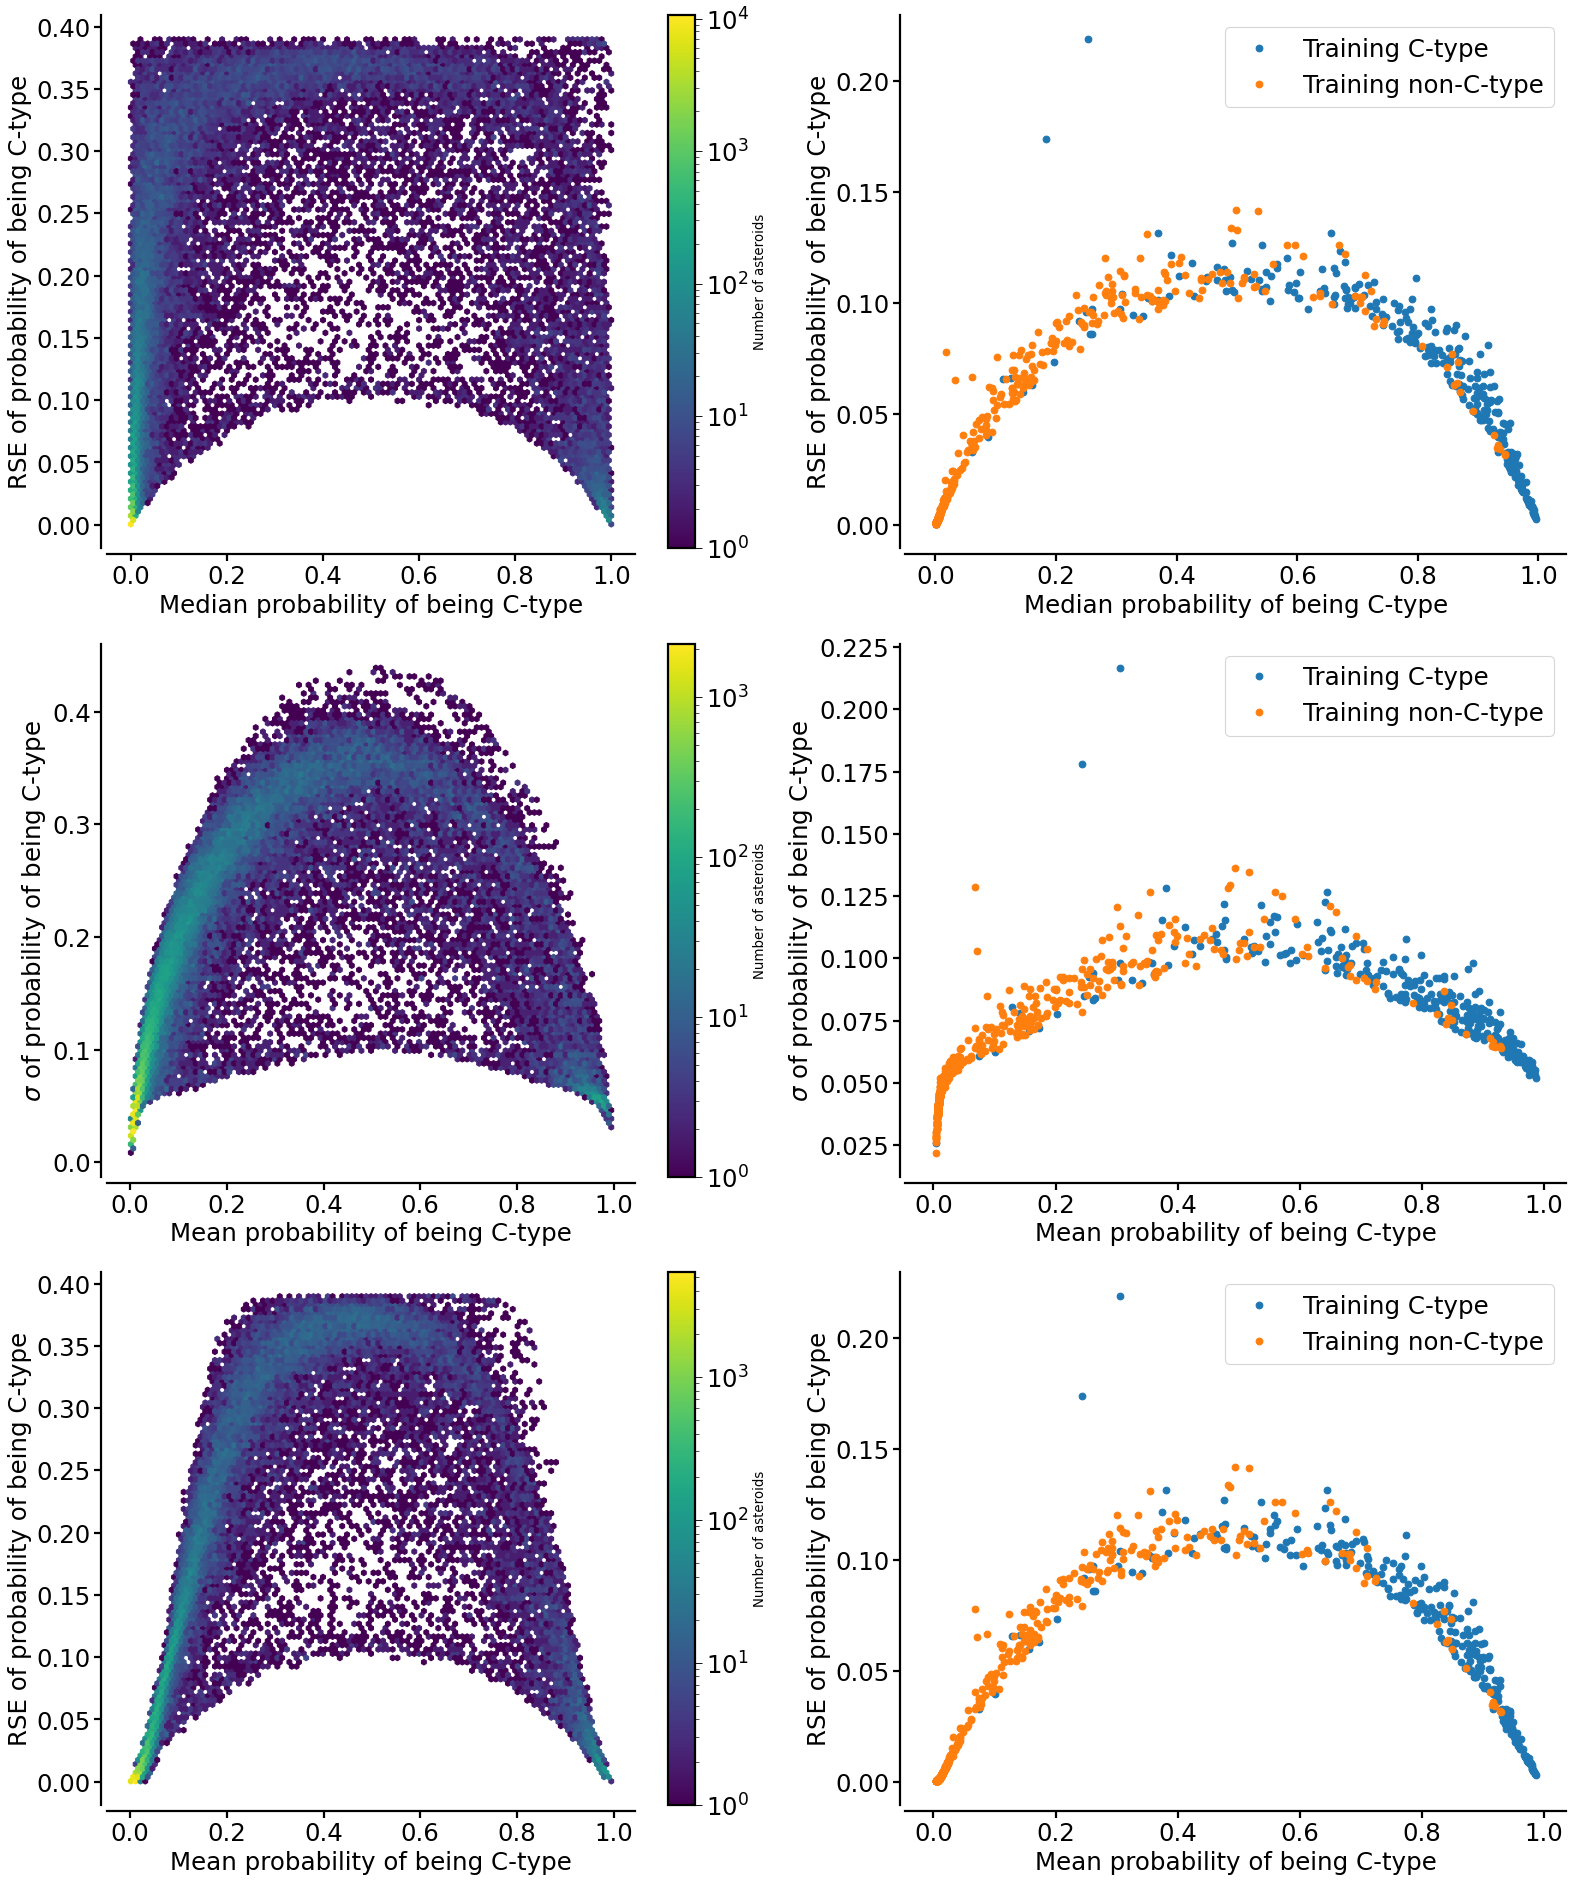

In [6]:
fig = plt.figure(figsize=(2 * 10, 3 * 8), tight_layout=True)
gs = GridSpec(3, 2, figure=fig)
axprobs = []
axprobs.append(fig.add_subplot(gs[0, 0]))
axprobs.append(fig.add_subplot(gs[0, 1]))
axprobs.append(fig.add_subplot(gs[1, 0]))
axprobs.append(fig.add_subplot(gs[1, 1]))
axprobs.append(fig.add_subplot(gs[2, 0]))
axprobs.append(fig.add_subplot(gs[2, 1]))
for axx in axprobs:
    apply_tufte(axx)

p_ctypes = ssoparams.ctype_median_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
rse_ctypes = ssoparams.ctype_rse_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
p_non_ctypes = ssoparams.ctype_median_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]
rse_non_ctypes = ssoparams.ctype_rse_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]

im = axprobs[0].hexbin(
    ssoparams.ctype_median_prob, ssoparams.ctype_rse_prob, mincnt=1, bins="log"
)
axprobs[0].set_xlabel("Median probability of being C-type")
axprobs[0].set_ylabel("RSE of probability of being C-type")
cbar = fig.colorbar(im, ax=axprobs[0])
cbar.set_label("Number of asteroids", fontsize=12)

axprobs[1].plot(p_ctypes, rse_ctypes, "o", label="Training C-type")
axprobs[1].plot(p_non_ctypes, rse_non_ctypes, "o", label="Training non-C-type")
axprobs[1].set_xlabel("Median probability of being C-type")
axprobs[1].set_ylabel("RSE of probability of being C-type")
axprobs[1].legend()

# Now mean and standard deviation

pm_ctypes = ssoparams.ctype_mean_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
std_ctypes = ssoparams.ctype_std_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
pm_non_ctypes = ssoparams.ctype_mean_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]
std_non_ctypes = ssoparams.ctype_std_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]

im = axprobs[2].hexbin(
    ssoparams.ctype_mean_prob, ssoparams.ctype_std_prob, mincnt=1, bins="log"
)
axprobs[2].set_xlabel("Mean probability of being C-type")
axprobs[2].set_ylabel(r"$\sigma$ of probability of being C-type")
cbar = fig.colorbar(im, ax=axprobs[2])
cbar.set_label("Number of asteroids", fontsize=12)

axprobs[3].plot(pm_ctypes, std_ctypes, "o", label="Training C-type")
axprobs[3].plot(pm_non_ctypes, std_non_ctypes, "o", label="Training non-C-type")
axprobs[3].set_xlabel("Mean probability of being C-type")
axprobs[3].set_ylabel(r"$\sigma$ of probability of being C-type")
axprobs[3].legend()

# Now mean and RSE

pm_ctypes = ssoparams.ctype_mean_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
std_ctypes = ssoparams.ctype_std_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
pm_non_ctypes = ssoparams.ctype_mean_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]
std_non_ctypes = ssoparams.ctype_std_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]

im = axprobs[4].hexbin(
    ssoparams.ctype_mean_prob, ssoparams.ctype_rse_prob, mincnt=1, bins="log"
)
axprobs[4].set_xlabel("Mean probability of being C-type")
axprobs[4].set_ylabel(r"RSE of probability of being C-type")
cbar = fig.colorbar(im, ax=axprobs[4])
cbar.set_label("Number of asteroids", fontsize=12)

axprobs[5].plot(pm_ctypes, rse_ctypes, "o", label="Training C-type")
axprobs[5].plot(pm_non_ctypes, rse_non_ctypes, "o", label="Training non-C-type")
axprobs[5].set_xlabel("Mean probability of being C-type")
axprobs[5].set_ylabel(r"RSE of probability of being C-type")
axprobs[5].legend()

plt.show()

Some further plots to explore the behaviour of the average and scatter statistics.

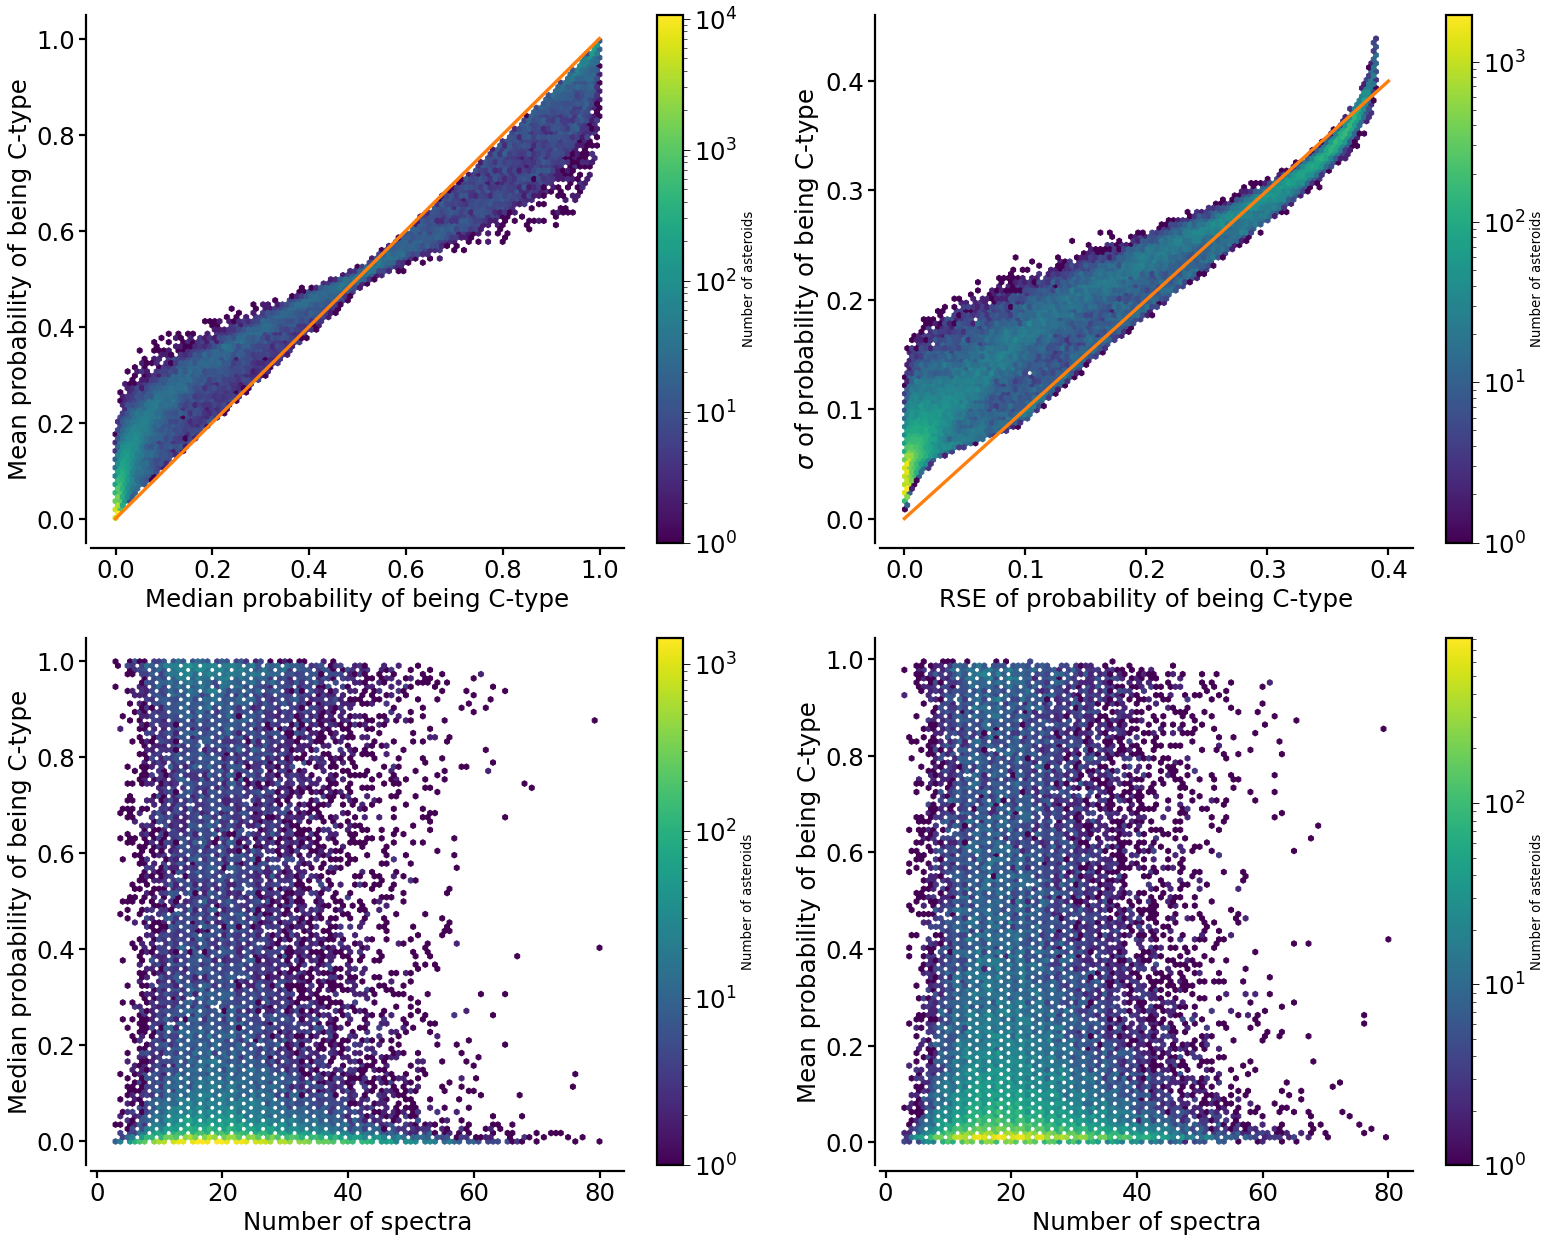

In [7]:
fig = plt.figure(figsize=(2 * 10, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axoth = []
axoth.append(fig.add_subplot(gs[0, 0]))
axoth.append(fig.add_subplot(gs[0, 1]))
axoth.append(fig.add_subplot(gs[1, 0]))
axoth.append(fig.add_subplot(gs[1, 1]))
for axx in axoth:
    apply_tufte(axx)

im = axoth[0].hexbin(
    ssoparams.ctype_median_prob, ssoparams.ctype_mean_prob, mincnt=1, bins="log"
)
axoth[0].plot([0, 1], [0, 1], "-C1")
axoth[0].set_xlabel("Median probability of being C-type")
axoth[0].set_ylabel("Mean probability of being C-type")
cbar = fig.colorbar(im, ax=axoth[0])
cbar.set_label("Number of asteroids", fontsize=12)

im = axoth[1].hexbin(
    ssoparams.ctype_rse_prob, ssoparams.ctype_std_prob, mincnt=1, bins="log"
)
axoth[1].plot([0, 0.4], [0, 0.4], "-C1")
axoth[1].set_xlabel("RSE of probability of being C-type")
axoth[1].set_ylabel(r"$\sigma$ of probability of being C-type")
cbar = fig.colorbar(im, ax=axoth[1])
cbar.set_label("Number of asteroids", fontsize=12)

im = axoth[2].hexbin(
    ssoparams.num_of_spectra, ssoparams.ctype_median_prob, mincnt=1, bins="log"
)
axoth[2].set_xlabel("Number of spectra")
axoth[2].set_ylabel("Median probability of being C-type")
cbar = fig.colorbar(im, ax=axoth[2])
cbar.set_label("Number of asteroids", fontsize=12)

im = axoth[3].hexbin(
    ssoparams.num_of_spectra, ssoparams.ctype_mean_prob, mincnt=1, bins="log"
)
axoth[3].set_xlabel("Number of spectra")
axoth[3].set_ylabel("Mean probability of being C-type")
cbar = fig.colorbar(im, ax=axoth[3])
cbar.set_label("Number of asteroids", fontsize=12)

plt.show()

### Class definitions
The plots above show that there is no very clear separation between C-types and other types for the training data, although the true positives dominate for $\theta\gtrsim0.8$. Selection of other C-type asteroids can then be done by demanding $\theta$ to be above this threshold. However to ensure a robust classification the scatter in the probabilities should be low. The question here is which statistics are best to used from among median and mean (for $\theta$), and RSE and standard deviation (for $\zeta$). 

The plots above show the following:
* The mean probabiltities tend to be larger than the median when $\theta$ is close to zero and smaller than the median when $\theta$ is close to 1.
* The standard deviation is mostly larger than the RSE.

This means that asteroids are more confidently classified as C-type or other when looking at the median probability. This is most likely due to a clustering of probabilties around two values. For example is about half the values are near class probability $p=0$ and the other half near $p=1$ the mean will (correctly) be $\sim0.5$, however the median will be either 0 or 1 if there is even a slight imbalance in the number of values in the two clusters. A similar descrepancy between mean and median occurs for peaked distributions with a heavy tail to one side, where again the mean better captures the uncertain classification. This argues for using the mean probability as one classification criterion as it more better captures the uncertainty when the distribution of $p$ is multimodal.

As a measure for the scatter, the RSE might be more appropriate in that it better captures the spread in values for a multimodal distribution if one of the peaks is dominant (which is related to the well-known sensitivity of the standard deviation to outliers).

The plot below shows the distributions of class probabilities $p$ for randomly chosen asteroids. It can be used to explore the above issues.

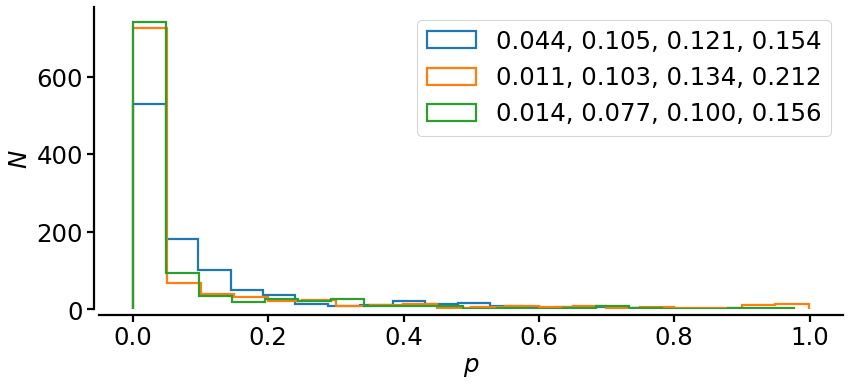

In [24]:
fig, axtheta = plt.subplots(1, 1, figsize=(12, 5))
apply_tufte(axtheta)

indices = np.random.choice(n_asteroids, size=3, replace=False)
for i in indices:
    ltext = (
        f"{ssoparams.loc[i]['ctype_median_prob']:.3f}, "
        + f"{ssoparams.loc[i]['ctype_mean_prob']:.3f}, "
        + f"{ssoparams.loc[i]['ctype_rse_prob']:.3f}, "
        + f"{ssoparams.loc[i]['ctype_std_prob']:.3f}"
    )
    axtheta.hist(
        probability_matrix[:, i], bins=20, histtype="step", alpha=1, lw=2, label=ltext
    )
axtheta.set_xlabel(r"$p$")
axtheta.set_ylabel("$N$")
axtheta.legend()

plt.show()

Based on the above arguments the class definitions are adopted, where $\theta$ refers to the __mean__ and $\zeta$ to the __RSE__.
* C-type $\theta\geq0.8$ and $\zeta\leq0.1$
* Non C-type $\theta\leq0.2$ and $\zeta\leq0.1$

The limit on $\zeta$ is to ensure that an asteroid is robustly classified as C-type.

Now we look at example spectra of asteroids confidently classified as C-type or "other" according to the above criteria.

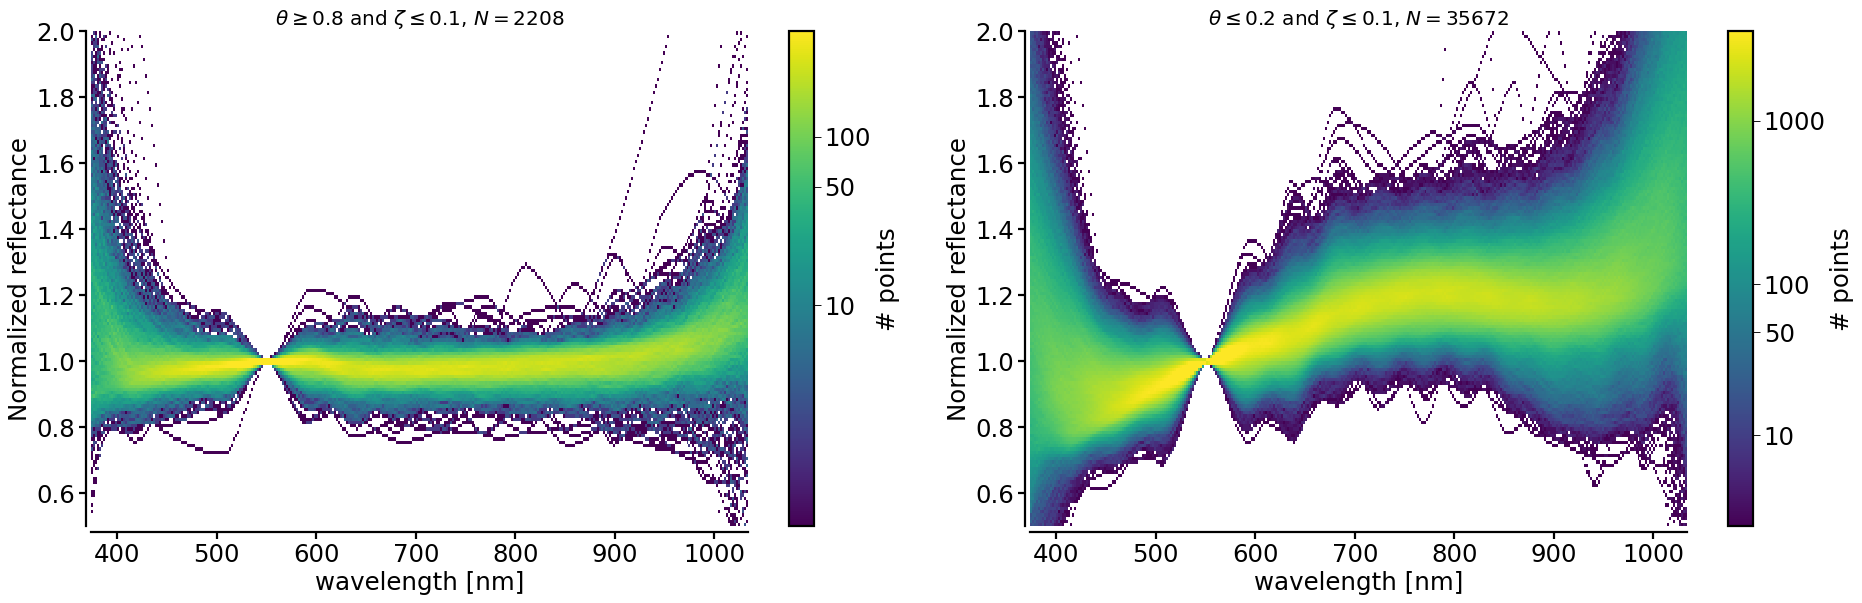

In [25]:
fig = plt.figure(figsize=(2 * 12, 8), tight_layout=True)
gs = GridSpec(1, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
axspectra.append(fig.add_subplot(gs[0, 1]))
for axx in axspectra:
    apply_tufte(axx)

rsemax = 0.1
stdmax = 0.1
pctype = 0.8
pnon = 0.2

ctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_mean_prob >= pctype) & (ssoparams.ctype_rse_prob <= rsemax)
].to_list()
nonctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_mean_prob <= pnon) & (ssoparams.ctype_rse_prob <= rsemax)
].to_list()

plot_spectra_collection(
    ssospectra, axspectra[0], fig, ctypes_nums, cbarticks=[10, 50, 100]
)
axspectra[0].set_title(
    rf"$\theta\geq{pctype}$ and $\zeta\leq{rsemax}$, $N={len(ctypes_nums)}$",
    fontsize=18,
)
axspectra[0].set_xlabel("wavelength [nm]")
axspectra[0].set_ylabel("Normalized reflectance")

plot_spectra_collection(
    ssospectra, axspectra[1], fig, nonctypes_nums, cbarticks=[10, 50, 100, 1000]
)
axspectra[1].set_title(
    rf"$\theta\leq{pnon}$ and $\zeta\leq{rsemax}$, $N={len(nonctypes_nums)}$",
    fontsize=18,
)
axspectra[1].set_xlabel("wavelength [nm]")
axspectra[1].set_ylabel("Normalized reflectance")

plt.show()